### Soft Actor Critic

#### Introduction:
* Maximizes long term rewards and entropy
* Similar to Q learning ( epsilon greedy - some % of the time selects random action )
* Entropy modeled by reward scaling ( inv. relationship )
* Networks:
    * 1 actor network
    * 1 value network
    * 2 critic networks (like ddqn/td3)
* Uses a target value function (soft update)
* Has replay buffer

#### Sampling:
* actor outputs mu and sigma and we use a normal dist from them

#### Network updates:
* Actor:
    * sample states from buffer, compute new actions
    * get the minimum of two critics
    * log is computed according to the previous slide
* Value:
    * use value fn (current params) for states
    * samples states and computes new actions
    * uses minimum value of two critics
    * log is computed according to the prev slide
* Target:
    * Uses a small tau ( 0.005 for ex )
    * Slowly moving avg of online and target network
* Critic:
    * target value fort new states
    * sample states and actions
    * reward is scaled here

#### Limitations:
* Only works in continous environments

In [1]:
import shutup
shutup.please()

In [2]:
import numpy as np

from src.agents.agent import Agent
from src.utils.buffer import Buffer
from src.utils.logger import LearningLogger

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_probability as tfp
from tensorflow.keras.layers import Input, Dense, Concatenate



In [3]:
import numpy as np

class ReplayBuffer:
    def __init__(self, buffer_size, input_shape, n_actions):
        self.buffer_size = buffer_size
        self.buffer_counter = 0
        self.state_memory = np.zeros((self.buffer_size, *input_shape))
        self.new_state_memory = np.zeros((self.buffer_size, *input_shape))
        self.action_memory = np.zeros((self.buffer_size, n_actions))
        self.reward_memory = np.zeros(self.buffer_size)
        self.done_memory = np.zeros(self.buffer_size, dtype=np.bool)

    def remember(self, state, action, reward, state_, done):
        index = self.buffer_counter % self.buffer_size

        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.done_memory[index] = done

        self.buffer_counter += 1

    def sample(self, batch_size=64):
        max_mem = min(self.buffer_counter, self.buffer_size)

        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        states_ = self.new_state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        dones = self.done_memory[batch]

        return states, actions, rewards, states_, dones

In [4]:
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_probability as tfp
from tensorflow.keras.layers import Dense 
from tensorflow.keras.optimizers import Adam

@tf.function
def trace_call(model, state):
    return model(state)

def MultiLayerPerceptron(policy="mlp"):
    layers = []
    if type(policy) == str:
        if policy == "mlp":
            layers.append(Dense(256, activation='relu', name="mlp_dense_layer_0"))
            layers.append(Dense(256, activation='relu', name="mlp_dense_layer_1"))
    else:
        for i,layer in enumerate(policy):
            layer._name = 'mlp_custom_layer_{}'.format(i)
            layers.append(layer)
            
    return layers
        

class CriticNetwork(keras.Model):
    def __init__(self,
                policy="mlp",
                n_actions=2,
                name='critic'
        ):
        super(CriticNetwork, self).__init__()
        
        
        self.model_name = name
        self.fc = MultiLayerPerceptron(policy=policy)
        self.q = Dense(1, activation=None)
        self._name = name
        
    def call(self, state, action):
        X = tf.concat([state, action], axis=1)

        for layer in self.fc:
            X = layer(X)
            
        q = self.q(X)
        return q

class ValueNetwork(keras.Model):
    def __init__(self,
                 policy="mlp",
                 name='value',  
        ):
        super(ValueNetwork, self).__init__()
        

        self.model_name = name

        self.fc = MultiLayerPerceptron(policy=policy)
        self.v = Dense(1, activation=None)
        self._name = name
        
    def call(self, state):
        X = state

        for layer in self.fc:
            X = layer(X)

        v = self.v(X)

        return v

class ActorNetwork(keras.Model):
    def __init__(self, 
            policy="mlp",
            n_actions=2,
            max_action=1, 
            name='actor', 
    ):
        super(ActorNetwork, self).__init__()

        self.model_name = name
        self.max_action = max_action
        self.noise = 1e-6

        self.fc = MultiLayerPerceptron(policy=policy)
        
        self.mu = Dense(n_actions, activation=None)
        self.sigma = Dense(n_actions, activation=None)
        
        self._name = name

    def call(self, state):
        X = state
        for layer in self.fc:
            X = layer(X)

        mu = self.mu(X)
        sigma = self.sigma(X)
        sigma = tf.clip_by_value(sigma, self.noise, 1)

        return mu, sigma

    def sample_normal(self, state, reparameterize=True):
        mu, sigma = self.call(state)
        probabilities = tfp.distributions.Normal(mu, sigma)

        if reparameterize:
            actions = probabilities.sample() # + something else if you want to implement
        else:
            actions = probabilities.sample()

        action = tf.math.tanh(actions)*self.max_action
        log_probs = probabilities.log_prob(actions)
        log_probs -= tf.math.log(1-tf.math.pow(action,2)+self.noise)
        log_probs = tf.math.reduce_sum(log_probs, axis=1, keepdims=True)

        return action, log_probs


In [5]:
from src.agents.agent import Agent


class SoftActorCriticAgent(Agent):
    def __init__(self, 
            environment,
            alpha=0.0003, 
            beta=0.0003, 
            gamma=0.99, 
            tau=0.005,
            buffer_size=1000000, 
            policy="mlp", 
            batch_size=256, 
            reward_scale=2, 
            loss_function = keras.losses.MSE, #keras.losses.Huber()
    ):
        super(SoftActorCriticAgent, self).__init__(environment,loss_keys=["actor","value","critic_1","critic_2"],args=locals())

        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.tau = tau
        self.policy = policy
        self.reward_scale = reward_scale
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.loss_function = loss_function
        
        self.__init_networks()
        self.__init_buffers()
        #self._add_models_to_config([self.actor,self.critic_1,self.critic_2,self.value,self.target_value])
        #self._init_tensorboard()
        
    def __init_buffers(self):
        self.buffer = ReplayBuffer(self.buffer_size, self.observation_shape, self.n_actions)
            
    def __init_networks(self):
        self.actor = ActorNetwork(n_actions=self.n_actions,policy=self.policy, max_action=self.env.action_space.high)
        self.critic_1 = CriticNetwork(n_actions=self.n_actions,policy=self.policy, name='critic_1')
        self.critic_2 = CriticNetwork(n_actions=self.n_actions,policy=self.policy, name='critic_2')
        self.value = ValueNetwork(name='value',policy=self.policy)
        self.target_value = ValueNetwork(name='target_value',policy=self.policy)

        self.actor.compile(optimizer=Adam(learning_rate=self.alpha))
        self.critic_1.compile(optimizer=Adam(learning_rate=self.beta))
        self.critic_2.compile(optimizer=Adam(learning_rate=self.beta))
        self.value.compile(optimizer=Adam(learning_rate=self.beta))
        self.target_value.compile(optimizer=Adam(learning_rate=self.beta))

        self.update_network_parameters(tau=1)
        
        self.models = [self.actor,self.critic_1,self.critic_2,self.value,self.target_value]
    
    def choose_action(self, observation):
        state = tf.convert_to_tensor([observation])
        actions, _ = self.actor.sample_normal(state, reparameterize=False)

        return actions[0]

    def remember(self, state, action, reward, new_state, done):
        self.buffer.remember(state, action, reward, new_state, done)      

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        weights = []
        targets = self.target_value.weights
        for i, weight in enumerate(self.value.weights):
            weights.append(weight * tau + targets[i]*(1-tau))

        self.target_value.set_weights(weights)
        
    def replay(self):
        if self.buffer.buffer_counter < self.batch_size:
            return
    
        state,action, reward, state_, done = self.buffer.sample(self.batch_size)
        
        states = tf.convert_to_tensor(state, dtype=tf.float32)
        states_ = tf.convert_to_tensor(state_, dtype=tf.float32)
        rewards = tf.convert_to_tensor(reward, dtype=tf.float32)
        actions = tf.convert_to_tensor(action, dtype=tf.float32)
        
        # Value network update
        with tf.GradientTape() as tape:
            value = tf.squeeze(self.value(states),1)
            value_= tf.squeeze(self.target_value(states_),1)
            #self.trace_call(self.actor.sample_normal,states,'actor_graph')
            current_policy_actions, log_probs = self.actor.sample_normal(states)
            log_probs = tf.squeeze(log_probs,1)
            
            q1_new_policy = self.critic_1(states,current_policy_actions)
            q2_new_policy = self.critic_2(states,current_policy_actions)
            critic_value = tf.squeeze(tf.math.minimum(q1_new_policy,q2_new_policy))
            
            value_target = critic_value - log_probs
            value_loss = 0.5 *self.loss_function(value,value_target)
            
            
        value_network_gradient = tape.gradient(value_loss,self.value.trainable_variables)
        self.value.optimizer.apply_gradients(zip(value_network_gradient, self.value.trainable_variables))
        
        # Actor network update
        with tf.GradientTape() as tape:
            # in the original paper, they reparameterize here. 
            new_policy_actions, log_probs = self.actor.sample_normal(states,reparameterize=True)
            
            log_probs = tf.squeeze(log_probs, 1)
            q1_new_policy = self.critic_1(states, new_policy_actions)
            q2_new_policy = self.critic_2(states, new_policy_actions)
            critic_value = tf.squeeze(tf.math.minimum(q1_new_policy, q2_new_policy), 1)
        
            actor_loss = log_probs - critic_value
            actor_loss = tf.math.reduce_mean(actor_loss)

        actor_network_gradient = tape.gradient(actor_loss, self.actor.trainable_variables)
        self.actor.optimizer.apply_gradients(zip(actor_network_gradient, self.actor.trainable_variables))

        # Critic network update
        with tf.GradientTape(persistent=True) as tape:
            
            q_hat = self.reward_scale*reward + self.gamma*value_*(1-done)
            q1_old_policy = tf.squeeze(self.critic_1(state, action), 1)
            q2_old_policy = tf.squeeze(self.critic_2(state, action), 1)
            critic_1_loss = 0.5 * self.loss_function(q1_old_policy, q_hat)
            critic_2_loss = 0.5 * self.loss_function(q2_old_policy, q_hat)
    
        critic_1_network_gradient = tape.gradient(critic_1_loss,self.critic_1.trainable_variables)
        critic_2_network_gradient = tape.gradient(critic_2_loss,self.critic_2.trainable_variables)

        self.critic_1.optimizer.apply_gradients(zip(critic_1_network_gradient, self.critic_1.trainable_variables))
        self.critic_2.optimizer.apply_gradients(zip(critic_2_network_gradient, self.critic_2.trainable_variables))

        # log losses
        self.learning_log.step_loss({
            "actor":actor_loss.numpy(),
            "value":value_loss.numpy(),
            "critic_1":critic_1_loss.numpy(),
            "critic_2":critic_2_loss.numpy()
        })
        
        self.update_network_parameters()

        # log evolution on tensorboard

        self.write_tensorboard_scaler('actor_loss',tf.get_static_value(actor_loss),self.learning_log.learning_steps)
        self.write_tensorboard_scaler('value_loss',tf.get_static_value(value_loss),self.learning_log.learning_steps)
        self.write_tensorboard_scaler('critic_1_loss',tf.get_static_value(critic_1_loss),self.learning_log.learning_steps)
        self.write_tensorboard_scaler('critic_2_loss',tf.get_static_value(critic_2_loss),self.learning_log.learning_steps)
    
    def trace_call(self,model,state,name):

        try:
            tf.summary.trace_on(graph=True, profiler=True)
        except:
            pass
        out = trace_call(model, state)

        with self.tensorboard_writer.as_default():
            tf.summary.trace_export(
                name=name, step=0, profiler_outdir=self.tensorboard_writer_log_directory
            )
        
        return out

    def test(self, episodes=10, render=True, init_environment=False):
        for episode in range(episodes):
            try:
                state = self.env.reset()
            except:
                self._Agent__init_environment()
                state = self.env.reset()
                
            done = False
            score = 0
            
            while not done:
                if render:
                    self.env.render()
                
                # Sample action, probs and critic
                action = self.choose_action(state)

                # Step
                state,reward,done, info = self.env.step(action)

                # Get next state
                score += reward
            
            if render:
                self.env.close()

            self.learning_log.episode_test_log(score,episode)

            
    def learn(self, timesteps=-1, plot_results=True, reset=False, success_threshold=False, log_level=1, log_each_n_episodes=50,):
        self.validate_learn(timesteps,success_threshold,reset)
        success_threshold = success_threshold if success_threshold else self.env.success_threshold
 
        score = 0
        timestep = 0
        episode = 0
        
        while self.learning_condition(timesteps,timestep):  # Run until solved
            state = self.env.reset()
            score = 0
            done = False
            
            while not done:
                action = self.choose_action(state)
                state_, reward, done, info = self.env.step(action)
                score += reward
                self.remember(state, action, reward, state_, done)
                self.replay()
                state = state_
            
            self.running_reward.step(score)
             # Log details
            episode += 1
            
            self.learning_log.episode(
                log_each_n_episodes,
                score,
                self.running_reward.reward, 
                log_level=log_level
            )
            
            # log scores
            self.write_tensorboard_scaler('score',score,self.learning_log.episodes)
           
            if self.did_finnish_learning(success_threshold,episode):
                break

        if plot_results:
            self.plot_learning_results()

Episode * 10 * Moving Avg Reward is ==> 31.900 * Last Reward was ==> 21.000
Episode * 20 * Moving Avg Reward is ==> 27.550 * Last Reward was ==> 14.000
Episode * 30 * Moving Avg Reward is ==> 25.467 * Last Reward was ==> 25.000
Episode * 40 * Moving Avg Reward is ==> 26.750 * Last Reward was ==> 25.000
Episode * 50 * Moving Avg Reward is ==> 28.260 * Last Reward was ==> 35.000
Episode * 60 * Moving Avg Reward is ==> 30.800 * Last Reward was ==> 32.000
Episode * 70 * Moving Avg Reward is ==> 46.760 * Last Reward was ==> 375.000
Episode * 80 * Moving Avg Reward is ==> 76.900 * Last Reward was ==> 198.000
Episode * 90 * Moving Avg Reward is ==> 108.440 * Last Reward was ==> 220.000
Episode * 100 * Moving Avg Reward is ==> 149.580 * Last Reward was ==> 181.000
Episode * 110 * Moving Avg Reward is ==> 187.020 * Last Reward was ==> 159.000
Episode * 120 * Moving Avg Reward is ==> 212.880 * Last Reward was ==> 168.000
Episode * 130 * Moving Avg Reward is ==> 226.100 * Last Reward was ==> 165.

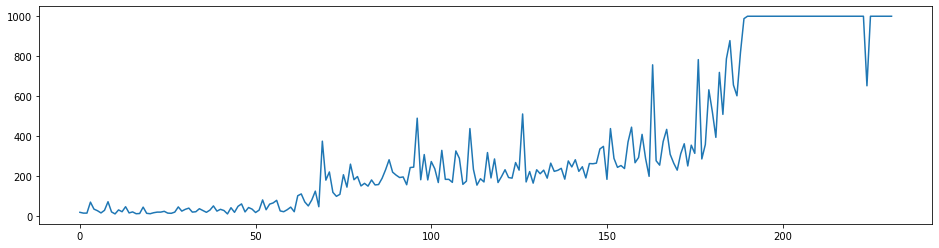

In [6]:
from src.environments.continuous.inverted_pendulum import environment

agent= SoftActorCriticAgent(environment)
agent.learn(log_each_n_episodes=10, success_threshold=950 )

In [7]:
#agent.tensorboard_writer_log_directory
#'storage/environments/Pendulum/DdpgAgent/e996ee6c856f7c9cad03964bbe0fa65e'

AttributeError: 'SoftActorCriticAgent' object has no attribute 'tensorboard_writer_log_directory'

In [ ]:
#%load_ext tensorboard
#%tensorboard --logdir storage/environments/InvertedPendulumBulletEnv/logs/88e695ba9c9146f81631e0b2fc3c9926__20220727-175543